## 1. Import Necessary Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [2]:
# beautifying matplotlib output 
import matplotlib_inline

plt.rcParams['font.family'] = 'Source Code Pro', 'serif'
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

## 2. Helper Functions

#### I. Generate Mock Data

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Function to generate mock data for tasks and robots
def generate_mock_data(num_tasks=10, num_robots=5):
    task_durations = np.random.randint(1, 11, size=num_tasks)  # Random task durations between 1 and 10 hours
    task_priorities = np.random.randint(1, 6, size=num_tasks)  # Random task priorities between 1 and 5
    #robot_efficiencies = np.random.uniform(0.5, 1.5, size=num_robots)  # Random robot efficiencies between 0.5 and 1.5
    robot_efficiencies = [0.1, 0.0002, 0.3, 0.4, 0.5]

    return task_durations, task_priorities, robot_efficiencies

#### II. Generate Random Population

In [4]:
def generate_population(population_size, num_tasks, num_robots):
    # generates an array of array where each index of each array,
    # represents a task and each element represents which robot will do that task
    return [np.random.randint(0, num_robots, size=num_tasks) for _ in range(population_size)]

#### III. Visualize Solution Using Grid

In [5]:
def visualize_grid(solution, task_durations, task_priorities, robot_efficiencies):
    # create a grid for visualization based on the solution provided
    grid = np.zeros((len(robot_efficiencies), len(task_durations)))
    annotations = np.empty((len(robot_efficiencies), len(task_durations)), dtype=object)

    for task_idx, robot_idx in enumerate(solution):
        duration = task_durations[task_idx]
        priority = task_priorities[task_idx]

        grid[robot_idx, task_idx] = duration

        for robot_index in range(len(robot_efficiencies)):
            annotations[robot_index, task_idx] = (duration, priority)

    fig, ax = plt.subplots(figsize=(12, 6))
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["white", "salmon"])  # custom colormap

    # display the grid with task durations
    cax = ax.matshow(grid, cmap=cmap)
    fig.colorbar(cax, label='Task Duration (hours)')

    # annotate each cell with task priority and duration
    for (i, j), val in np.ndenumerate(annotations):
        if val:  # check if cell is assigned
            duration, priority = val
            ax.text(j, i, f"P{priority}\n{duration}h", ha='center', va='center', fontsize=8)

    # set the ticks and labels for tasks and robots
    ax.set_xticks(np.arange(len(task_durations)))
    ax.set_yticks(np.arange(len(robot_efficiencies)))
    ax.set_xticklabels([f'Task {i+1}' for i in range(len(task_durations))], rotation=45, ha="left")
    ax.set_yticklabels([f'Robot {i+1} (Efficiency: {eff:.5f})' for i, eff in enumerate(robot_efficiencies)])

    plt.xlabel('Tasks')
    plt.ylabel('Robots')
    plt.title('Task Assignments with Task Duration and Priority')

    # create a legend for task priorities
    priority_patches = [mpatches.Patch(color='white', label=f'Priority {i}') for i in range(1, 6)]
    plt.legend(handles=priority_patches, bbox_to_anchor=(1.20, 1), loc='upper left', title="Task Priorities")

    plt.tight_layout()
    plt.show()

## 3. Main Genetic Algorithm functions implementation

In [6]:
def fitness(task_assignments, robot_efficiencies, task_priorities):
    total_times = np.zeros(len(robot_efficiencies))

    for task, robot in enumerate(task_assignments):
        total_times[robot] += ((task_durations[task] * task_priorities[task]) / robot_efficiencies[robot])
        
    total_production_time = np.max(total_times)
    workload_balance = np.std(total_times)
    
    return 1 / (total_production_time + workload_balance)

def selection(population, fitness_scores, num_parents):
    # tournament selection
    population_size = len(population)
    tournament_size = population_size // 6

    selected_parents = np.empty(num_parents, dtype=object)

    for i in range(num_parents):
        # randomly select individuals for the tournament
        tournament_indices = np.random.choice(population_size, tournament_size, replace=False)
        tournament_fitness_scores = [fitness_scores[i] for i in tournament_indices]
        
        # find the index of the winner (individual with the highest fitness) in the tournament
        winner_index = tournament_indices[np.argmax(tournament_fitness_scores)]

        # add the winner to the selected parents
        selected_parents[i] = population[winner_index]

    return selected_parents

def crossover(parents, offspring_size):
    offsprings = []
    
    for i in range(offspring_size // 2):
        # select two parents for crossover
        parent1 = parents[i % len(parents)]
        parent2 = parents[(i + 1) % len(parents)]
        
        # randomly choose a crossover point
        crossover_point = np.random.randint(1, len(parent1))
        
        # perform single-point crossover
        offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        
        offsprings.append(offspring1)
        offsprings.append(offspring2)
    
    return offsprings

def mutation(offspring_crossover):
    mutated_offspring = np.copy(offspring_crossover)

    for offspring in mutated_offspring:
        # randomly select two tasks to swap robots
        task1_index, task2_index = np.random.choice(len(offspring), 2, replace=False)

        # swap the robots assigned to these tasks
        offspring[task1_index], offspring[task2_index] = offspring[task2_index], offspring[task1_index]

    return mutated_offspring

In [7]:
def run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies, num_tasks, num_robots):
    # initialize genetic algorithm parameters 
    population_size = 50 
    max_generations = 1000
    num_parents = population_size // 2

    population = generate_population(population_size=population_size, num_tasks=num_tasks, num_robots=num_robots)

    for generation in range(max_generations):
        fitness_scores = [fitness(task_assignments=sample, robot_efficiencies=robot_efficiencies, task_priorities=task_priorities) for sample in population]

        selected_parents = selection(population=population, fitness_scores=fitness_scores, num_parents=num_parents)

        offspring_crossover = crossover(parents=selected_parents, offspring_size=population_size-num_parents)

        offspring_mutated = mutation(offspring_crossover=offspring_crossover)
        
        population[:len(selected_parents)] = selected_parents
        population[len(selected_parents):] = offspring_mutated

    fitness_scores = [fitness(task_assignments=sample, robot_efficiencies=robot_efficiencies, task_priorities=task_priorities) for sample in population]
    best_solution = population[fitness_scores.index(max(fitness_scores))]

    for i in range(num_robots):
        print(f"Robot-{i + 1}: {i}")
    print(f"Best solution: {best_solution}")
    
    return best_solution

## 4. Simulation of the tasks and robots

Robot-1: 0
Robot-2: 1
Robot-3: 2
Robot-4: 3
Robot-5: 4
Best solution: [4 4 3 4 3 2 0 4 2 2]


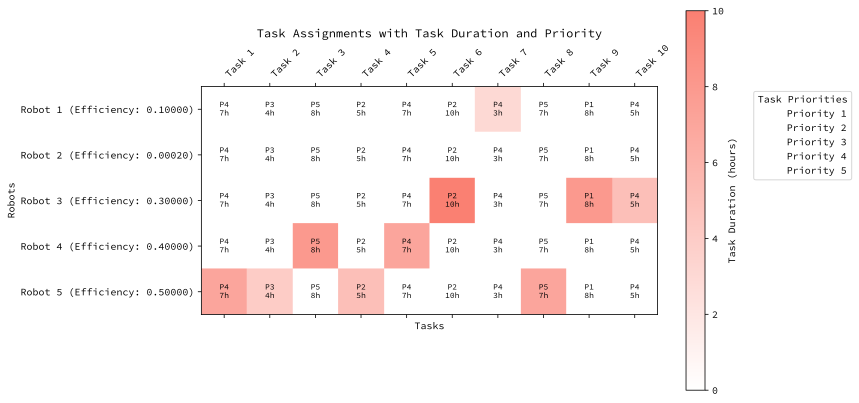

In [8]:
# Main execution
if __name__ == "__main__":
    num_tasks = 10
    num_robots = 5
    task_durations, task_priorities, robot_efficiencies = generate_mock_data(num_tasks, num_robots)

    # Run GA to find the best solution
    best_solution = run_genetic_algorithm(task_durations, task_priorities, robot_efficiencies, num_tasks, num_robots)

    # Visualize the initial random assignment
    visualize_grid(best_solution, task_durations, task_priorities, robot_efficiencies)
